# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, validation_curve,cross_validate, KFold, cross_val_predict,GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.pipeline import make_pipeline
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline


In [2]:
# read in the json files
df = pd.read_json('data/Cleaned_Dataset.json', orient='records')
df.head()


,gender,age,income,membership_days,person,event,offer id,amount,reward,difficulty,duration,offer_type,channels,offer_driven,active_customer,offer_irrelevant,offer_cnt
0,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_10.0_168.0,0.00,2,10,168,discount,3,0,1,0,5
1,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_20.0_240.0,0.35,5,20,240,discount,2,1,1,0,5
2,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_10.0_240.0,0.74,2,10,240,discount,4,1,1,0,5
3,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,1.89,0,0,0,NoOffer,0,0,1,1,5
4,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_7.0_168.0,5.04,3,7,168,discount,4,1,1,0,5


# Helper Functions

In [3]:
def dummied_df(df):
    cat_cols=df.select_dtypes(include=['object']).copy().columns 
    print(cat_cols)
    for col in cat_cols:
        df=pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    return df


def pre_data(X,y,perc):
    
    # split data into train and test
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=perc, random_state=101)
    
    # scale X_train
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # get feature list
    col_list=X.columns
    
    return X_train, y_train, X_test, y_test, col_list


def plot_validation_curve(clf,X,Y,param,paramlist,K,x_label,ptitle):

    train_score, valid_score = validation_curve(clf, X, Y, param_name=param, param_range=paramlist, cv=K, scoring='accuracy')

    train_score_mean = train_score.mean(1)
    train_score_std = train_score.std(1)
    valid_score_mean = valid_score.mean(1)
    valid_score_std = valid_score.std(1)

    plt.grid()
    plt.fill_between(paramlist, train_score_mean - train_score_std,
                     train_score_mean + train_score_std, color='r', alpha=0.1)
    plt.fill_between(paramlist, valid_score_mean - valid_score_std,
                     valid_score_mean + valid_score_std, color='g', alpha=0.1)

    plt.plot(paramlist, train_score_mean, 'o-', c='r', label='train score')
    plt.plot(paramlist, valid_score_mean, 'o-', c='g', label='validation score')
    plt.legend(loc='best')
    plt.title(ptitle)
    plt.xlabel(x_label)
    plt.ylabel('neg_mean_squared_error')
    plt.savefig(ptitle)
    plt.show()


def learning_curve_plot(estimator, X, y, cv, score, title, ylims=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=score, train_sizes= np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title('Learning Curve')
    # axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                      train_scores_mean + train_scores_std, alpha=0.1,color="r")
    
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                      test_scores_mean + test_scores_std, alpha=0.1,color="g")
    
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    
    axes.set_ylim(ylims)
    
    axes.legend(loc="best")
    plt.savefig(title)
    
    
def ft_importance(fi_list, col):
    fi=pd.DataFrame(fi_list, columns=['weight'], index=col).reset_index().sort_values('weight', ascending=False)
    fi['cum_sum']=fi['weight'].cumsum()
    
    plt.figure(figsize=(4,8))
    palette=sns.color_palette("Blues_r", fi.shape[0])
    sns.barplot(x='weight', y='index',data=fi, palette=palette)
    plt.title('Feature Importance from Randome Forest Model -a First Try')
    plt.xlabel('Feature Importance')
    plt.margins(y=0.01)
    plt.show()
    
    return fi


def model_evaluation_class(model, X_train, X_test, y_train, y_test):
    
    st=time.time()
    model=model.fit(X_train,y_train)
    et=time.time()
    y_test_predict=model.predict(X_test)
    y_train_predict=model.predict(X_train)
    
#     print(classification_report(y_test, y_test_predict))
    print("Accuracy score of optimal model on training set is", round(accuracy_score(y_train, y_train_predict), 4))
    print("Accuracy score of optimal model on test set is",round(accuracy_score(y_test, y_test_predict), 4))


def model_evaluation_reg(model, X_train, X_test, y_train, y_test, title):
    
    st=time.time()
    model=model.fit(X_train,y_train)
    et=time.time()
    y_test_predict=model.predict(X_test)
    y_train_predict=model.predict(X_train)
    
    train_MAE=round(mean_absolute_error(y_train, y_train_predict),4)
    test_MAE=round(mean_absolute_error(y_test, y_test_predict),4)
    train_MSE=round(mean_squared_error(y_train, y_train_predict),4)
    test_MSE=round(mean_squared_error(y_test, y_test_predict),4)
    train_r2=round(r2_score(y_train, y_train_predict),4)
    test_r2=round(r2_score(y_test, y_test_predict),4)

    
    print("Training time =", round(et-st,4), 'seconds')
    print("\nTraining MAE =", train_MAE)
    print("Validation MAE =", test_MAE)
    print("\nTraining MSE =", train_MSE)
    print("Validation MSE =", test_MSE)
    print("\nTraining r2 =", train_r2)
    print("Validation r2 =", test_r2)

    plot_regression_results(y_test, y_test_predict, title, False, '0')
    

def plot_regression_results(y_true, y_pred, title, show, scores):
    
    """Scatter plot of the predicted vs true targets."""
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    if show:
        extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                              edgecolor='none', linewidth=0)
        ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)
    plt.savefig(title)
    

In [4]:
df.head(10)

,gender,age,income,membership_days,person,event,offer id,amount,reward,difficulty,duration,offer_type,channels,offer_driven,active_customer,offer_irrelevant,offer_cnt
0,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_10.0_168.0,0.00,2,10,168,discount,3,0,1,0,5
1,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_20.0_240.0,0.35,5,20,240,discount,2,1,1,0,5
2,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_10.0_240.0,0.74,2,10,240,discount,4,1,1,0,5
3,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,1.89,0,0,0,NoOffer,0,0,1,1,5
4,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_7.0_168.0,5.04,3,7,168,discount,4,1,1,0,5
5,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,0.38,0,0,0,NoOffer,0,0,1,1,5
6,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,2.12,0,0,0,NoOffer,0,0,1,1,5
7,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,offer received,discount_10.0_240.0,4.61,2,10,240,discount,4,1,1,0,5
8,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,0.06,0,0,0,NoOffer,0,0,1,1,5
9,unknown,unknown,unknown,1174,68be06ca386d4c31939f3a4f0e3dd783,transaction,unknown,5.21,0,0,0,NoOffer,0,0,1,1,5


## 	Q1: whether or not someone will respond to an offer


### Prepare Dataset

In [291]:
X=df[df['active_customer']==1][['gender', 'age', 'income', 'membership_days', 'offer id', 'offer_driven']]
X.drop_duplicates(inplace=True)

y=X['offer_driven']
X.drop(columns=['offer_driven'], axis=1, inplace=True)

X=dummied_df(X)
X_train, y_train, X_test, y_test, col_list=pre_data(X,y, 0.20)


Index(['gender', 'age', 'income', 'offer id'], dtype='object')


### Modeling

#### Random Forest

In [301]:
clf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=9, random_state=0)
model_evaluation_class(clf, X_train, X_test, y_train, y_test)

Accuracy score of optimal model on training set is 0.7198743100352464
Accuracy score of optimal model on test set is 0.7129746624991687


#### KNN

In [292]:
clf=KNeighborsClassifier(n_neighbors=15, weights='uniform', p=2)
model_evaluation_class(clf, X_train, X_test, y_train, y_test)

Accuracy score of optimal model on training set is 0.741387909822438
Accuracy score of optimal model on test set is 0.7022012369488595


## Q2: how much someone will spend

In [46]:
X=df[(df['amount']>0) &((df['offer_driven']==1) | (df['offer_irrelevant']==1))][['gender', 'age', 'income', 'membership_days','offer id','amount']]
X=X.groupby(['gender', 'age', 'income', 'membership_days','offer id'])[['amount']].mean().reset_index().drop_duplicates()

X

,gender,age,income,membership_days,offer id,amount
0,F,20-40,40-60k,651,unknown,10.440
1,F,20-40,40-60k,653,bogo_10.0_120.0,3.240
2,F,20-40,40-60k,653,discount_7.0_168.0,0.670
3,F,20-40,40-60k,653,unknown,4.485
4,F,20-40,40-60k,654,bogo_10.0_168.0,6.400
...,...,...,...,...,...,...
46269,unknown,unknown,unknown,2464,bogo_10.0_120.0,0.610
46270,unknown,unknown,unknown,2464,bogo_5.0_120.0,7.660
46271,unknown,unknown,unknown,2464,discount_10.0_168.0,0.200
46272,unknown,unknown,unknown,2464,informational_0.0_72.0,6.240


,amount
mean,14.257
std,28.343
min,0.050
25%,3.440
50%,11.590
75%,20.149
max,1015.730


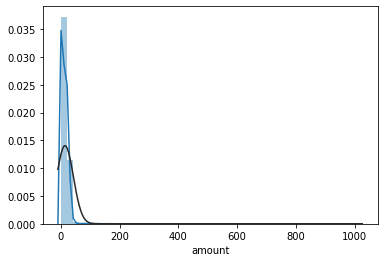

In [47]:
# Check the original distribution 
sns.distplot(X['amount'] , fit=norm);
round(X[['amount']].describe()[1:],3)

The mean (14.26) is slightly higher than the median (11.59), indicating the data is a little bit skewed right. 

Moreover, the 75% value is only 20.15 while the max is >1000. After researching how to handle outliers in output variables, I found a very useful [Medium article](https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07) discussing several methods to handle outliers. 

I will dropping values based on the IQR method first and perform a log-scale transformation then. Also both MAE and MSE will be used to evaluate model performances. 

In [48]:
# use the IQR method identify the upper limit above which values are considered outliers (Q3 + 1.5*IQR)
Q3 = np.percentile(X['amount'],75)
Q1 = np.percentile(X['amount'],25)
IQR = Q3-Q1
upper_limit = Q3 + 1.5*IQR
print('The upper limit using the IQR method is {:.2f}'.format(upper_limit))
X=X[X['amount']<=upper_limit]

The upper limit using the IQR method is 45.21


,amount
mean,12.607
std,9.676
min,0.050
25%,3.410
50%,11.440
75%,19.903
max,45.190


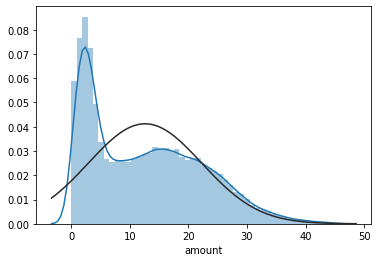

In [49]:
sns.distplot(X['amount'] , fit=norm);
round(X[['amount']].describe()[1:],3)


 mu = 12.61 and sigma = 9.68



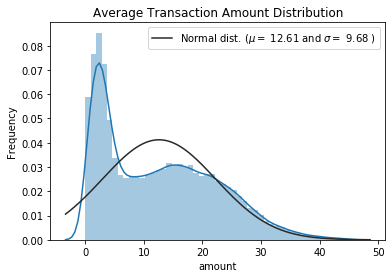

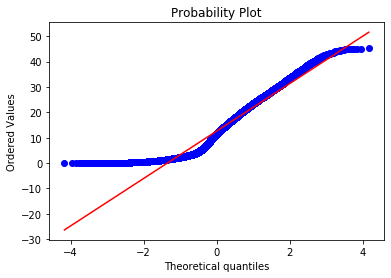

In [50]:

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# X['amount']= np.log1p(X['amount'])

#Check the new distribution 
sns.distplot(X['amount'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['amount'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Average Transaction Amount Distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['amount'], plot=plt)
plt.show()

In [51]:
y=X['amount']
X.drop(columns=['amount'], axis=1, inplace=True)

X=dummied_df(X)
X_train, y_train, X_test, y_test, col_list=pre_data(X,y, 0.20)

Index(['gender', 'age', 'income', 'offer id'], dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Random Forest Regressor

Training time = 7.166 seconds

Training MAE = 4.0394
Validation MAE = 4.3485

Training MSE = 28.9445
Validation MSE = 33.8901

Training r2 = 0.6912
Validation r2 = 0.6361


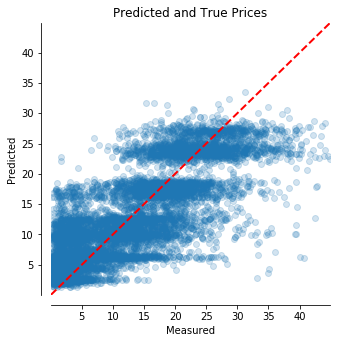

In [52]:
rfr=RandomForestRegressor(max_depth=12, n_estimators=100, random_state=20)
model_evaluation_reg(rfr, X_train, X_test, y_train, y_test, 'Predicted and True Prices')

Training time = 4.624 seconds

Training MAE = 4.3182
Validation MAE = 4.55

Training MSE = 33.1275
Validation MSE = 36.7583

Training r2 = 0.6466
Validation r2 = 0.6053


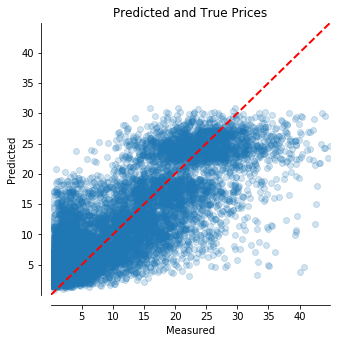

In [53]:
clf=KNeighborsRegressor(n_neighbors=15, weights='uniform', p=2)
model_evaluation_reg(clf, X_train, X_test, y_train, y_test, 'Predicted and True Prices')